# Random Forest and XGBoost Models

Using scikit-learn, we will build two tree based models, random forests, and XGBoost to predict user churn

## Python Libraries

**pandas** – For data loading, cleaning, and transformation \
**numpy** – For numerical operations \
**seaborn & matplotlib** – For visualizing trends and variable distributions \
**scikit-learn** - For logistic regression and ML workflows \
**xgboost** - For gradient boosting in classification and regression

In [29]:
import numpy as np
import pandas as pd

# data visualization
import matplotlib.pyplot as plt

# data modeling
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
f1_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance

# saving models
import pickle

In [30]:
df0 = pd.read_csv(r'C:\Users\mqtth\Desktop\Projects\Waze_Churn_ML_Project\data\waze_dataset.csv')

In [31]:
df0.head()

,ID,label,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,device
0,0,retained,283,226,296.748273,2276,208,0,2628.845068,1985.775061,28,19,Android
1,1,retained,133,107,326.896596,1225,19,64,13715.920550,3160.472914,13,11,iPhone
2,2,retained,114,95,135.522926,2651,0,0,3059.148818,1610.735904,14,8,Android
3,3,retained,49,40,67.589221,15,322,7,913.591123,587.196542,7,3,iPhone
4,4,retained,84,68,168.247020,1562,166,5,3950.202008,1219.555924,27,18,Android


In [32]:
df = df0.copy()

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       14999 non-null  int64  
 1   label                    14299 non-null  object 
 2   sessions                 14999 non-null  int64  
 3   drives                   14999 non-null  int64  
 4   total_sessions           14999 non-null  float64
 5   n_days_after_onboarding  14999 non-null  int64  
 6   total_navigations_fav1   14999 non-null  int64  
 7   total_navigations_fav2   14999 non-null  int64  
 8   driven_km_drives         14999 non-null  float64
 9   duration_minutes_drives  14999 non-null  float64
 10  activity_days            14999 non-null  int64  
 11  driving_days             14999 non-null  int64  
 12  device                   14999 non-null  object 
dtypes: float64(3), int64(8), object(2)
memory usage: 1.5+ MB


#### Feature Engineering

Create a `km_per_driving_day` feature which represents the mean number of kilometers driven on each driving day in the last month for each user.

In [34]:
df['km_per_driving_day'] = df['driven_km_drives'] / df['driving_days']

df['km_per_driving_day'].describe()

C:\Users\mqtth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


count    1.499900e+04
mean              inf
std               NaN
min      3.022063e+00
25%      1.672804e+02
50%      3.231459e+02
75%      7.579257e+02
max               inf
Name: km_per_driving_day, dtype: float64

In [35]:
# convert infinite values to zero
df.loc[df['km_per_driving_day']==np.inf, 'km_per_driving_day'] = 0

df['km_per_driving_day'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 14999 entries, 0 to 14998
Series name: km_per_driving_day
Non-Null Count  Dtype  
--------------  -----  
14999 non-null  float64
dtypes: float64(1)
memory usage: 117.3 KB


Create new column `percent_sessions_in_last_month` that represents the percentage of each user's total sessions that were logged in their last month of use

In [36]:
df['percent_sessions_in_last_month'] = df['sessions'] / df['total_sessions']

df['percent_sessions_in_last_month'].describe()

count    14999.000000
mean         0.449255
std          0.286919
min          0.000000
25%          0.196221
50%          0.423097
75%          0.687216
max          1.530637
Name: percent_sessions_in_last_month, dtype: float64

We will create a new column `professional_driver` that is a 1 for users who had 60 or more drives and drive 15+ days in the past month. These deciding thresholds are arbitrary. 

In [37]:
# create professional driver column
df['professional_driver'] = np.where((df['drives'] >= 60) & (df['driving_days'] >= 15), 1, 0)


Create column `total_sessions_per_day` that represents the mean number of sessions per day since onboarding

In [38]:
df['total_sessions_per_day'] = df['total_sessions'] / df['n_days_after_onboarding']

df['total_sessions_per_day'].describe()

count    14999.000000
mean         0.338698
std          1.314333
min          0.000298
25%          0.051037
50%          0.100775
75%          0.216269
max         39.763874
Name: total_sessions_per_day, dtype: float64

Create a column `km_per_hour` representing the mean kilometers per hour driven in the last month

In [39]:
df['km_per_hour'] = df['driven_km_drives'] / (df['duration_minutes_drives'] / 60)

df['km_per_hour'].describe()

count    14999.000000
mean       190.394608
std        334.674026
min         72.013095
25%         90.706222
50%        122.382022
75%        193.130119
max      23642.920871
Name: km_per_hour, dtype: float64

The max speed is obviously unrealistic. Perhaps seeking clarification from Waze regarding the collection of these features would help to better understand why these problematic speeds are observed. 

Create a `km_per_drive` column representing the mean number of km per drive in the last month.

In [40]:
df['km_per_drive'] = df['driven_km_drives'] / df['drives']
df['km_per_drive'].describe()

C:\Users\mqtth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


count    1.499900e+04
mean              inf
std               NaN
min      1.008775e+00
25%      3.323065e+01
50%      7.488006e+01
75%      1.854667e+02
max               inf
Name: km_per_drive, dtype: float64

Convert infinite values to 0

In [41]:
df.loc[df['km_per_drive']==np.inf, 'km_per_drive'] = 0

df['km_per_drive'].describe()

count    14999.000000
mean       232.817946
std        620.622351
min          0.000000
25%         32.424301
50%         72.854343
75%        179.347527
max      15777.426560
Name: km_per_drive, dtype: float64

Create a column `percent_of_sessions_to_favorite` that represents the percentage of total sessions that were used to navigate to one of the users' favorite places.

In [42]:
df['percent_of_drives_to_favorite'] = (
    df['total_navigations_fav1'] + df['total_navigations_fav2']) / df['total_sessions']

df['percent_of_drives_to_favorite'].describe()

count    14999.000000
mean         1.665439
std          8.865666
min          0.000000
25%          0.203471
50%          0.649818
75%          1.638526
max        777.563629
Name: percent_of_drives_to_favorite, dtype: float64

Dropping Missing Values

In [43]:
df = df.dropna(subset=['label'])

#### Variable Encoding

We will have to convert `device` into binary since it is categorical. 

In [44]:
df['device2'] = np.where(df['device']=='Android', 0, 1)
df[['device', 'device2']].tail()

,device,device2
14994,iPhone,1
14995,Android,0
14996,iPhone,1
14997,iPhone,1
14998,iPhone,1


#### Target Encoding

The target variable, `label`, is also categorical, so we must convert it into binary. \

Assign `0` for all `retained` users \
Assign `1` for all `churned` users


In [45]:
df['label2'] = np.where(df['label']=='churned', 1, 0)
df[['label', 'label2']].tail()

,label,label2
14994,retained,0
14995,retained,0
14996,retained,0
14997,churned,1
14998,retained,0


#### Feature Selection

Cut `ID` because it does not contain any information relevant to churn.

In [46]:
df = df.drop(['ID'], axis=1)

#### Deciding on an Evaluation Metric

In [47]:
df['label'].value_counts(normalize=True)

label
retained    0.822645
churned     0.177355
Name: proportion, dtype: float64

The churned approximation for this dataset is around 18%. Although this dataset is unbalanced, it is not extremely unbalanced. We do not need to do any class rebalancing.

The risks involving in making a false positive prediction (predicting a user will churn which in reality they do not) are minimal. There is no significant concequence if a user is predicted to churn. We will select the model based on recall score because the main goal is to catch as many real churners as possible. 

#### Splitting the Data
we will follow a 60/20/20 train/validation/test split

In [48]:
# assign variables
X = df.drop(columns=['label', 'label2', 'device'])
y = df['label2']

# split into train and test sets
X_tr, X_test, y_tr, y_test = train_test_split(X, y, stratify=y,
                                              test_size=0.2, random_state=42)

# split into train and validate sets
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, stratify=y_tr,
                                                  test_size=0.25, random_state=42)

# check how many samples in the partitioned data
for x in [X_train, X_val, X_test]:
    print(len(x))

8579
2860
2860


### Modeling

#### Random Forest

In [50]:
# instantiate the random forest classifier
rf = RandomForestClassifier(random_state=42)

# create a dictionary of hyperparameters
cv_params = {'max_depth': [None],
             'max_features': [1.0],
             'max_samples': [1.0],
             'min_samples_leaf': [2],
             'min_samples_split': [2],
             'n_estimators': [300],
             }

# define list of scoring metrics to capture
scoring = ['accuracy', 'precision', 'recall', 'f1']

# instantiate the GridSearchCV object
rf_cv = GridSearchCV(rf, cv_params, scoring=scoring, cv=4, refit='recall')

In [51]:
# fit the model to training data
rf_cv.fit(X_train, y_train)

GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [None], 'max_features': [1.0],
                         'max_samples': [1.0], 'min_samples_leaf': [2],
                         'min_samples_split': [2], 'n_estimators': [300]},
             refit='recall', scoring=['accuracy', 'precision', 'recall', 'f1'])

In [52]:
# examine best average score across all validation folds
print(rf_cv.best_score_)

# examine best hyperparameter combo
print(rf_cv.best_params_)

0.12678201409034398
{'max_depth': None, 'max_features': 1.0, 'max_samples': 1.0, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}


In [54]:
# Function adapted from the [Google Advanced Data Analytics Certificate].
# Date Accessed: June 11, 2025

def make_results(model_name:str, model_object, metric:str):
    '''
    Arguments:
        model_name (string): what you want the model to be called in the output table
        model_object: a fit GridSearchCV object
        metric (string): precision, recall, f1, or accuracy

    Returns a pandas df with the F1, recall, precision, and accuracy scores
    for the model with the best mean 'metric' score across all validation folds.
    '''

    # Create dictionary that maps input metric to actual metric name in GridSearchCV
    metric_dict = {'precision': 'mean_test_precision',
                   'recall': 'mean_test_recall',
                   'f1': 'mean_test_f1',
                   'accuracy': 'mean_test_accuracy',
                   }

    # Get all the results from the CV and put them in a df
    cv_results = pd.DataFrame(model_object.cv_results_)

    # Isolate the row of the df with the max(metric) score
    best_estimator_results = cv_results.iloc[cv_results[metric_dict[metric]].idxmax(), :]

    # Extract accuracy, precision, recall, and f1 score from that row
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy

    # Create table of results
    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision],
                          'recall': [recall],
                          'F1': [f1],
                          'accuracy': [accuracy],
                          },
                         )

    return table

#

In [55]:
results = make_results('RF cv', rf_cv, 'recall')
results

,model,precision,recall,F1,accuracy
0,RF cv,0.457163,0.126782,0.198445,0.81851


Apart from accuracy, the scores are not the best. On the other hand, the recall for this model showed around a 33% improvement from the previous linear regression model which yielded a recall score of 0.09. Also good to note that this was trained on less data.

#### XGBoost

In [56]:
# instantiate XGBoost classifier
xgb = XGBClassifier(objective='binary:logistic', random_state=42)

# create a dictionary of hyperparameters
cv_params = {'max_depth': [6, 12],
             'min_child_weight': [3, 5],
             'learning_rate': [0.01, 0.1],
             'n_estimators': [300]
             }

# define a list of scoring metrics
scoring = ['accuracy', 'precision', 'recall', 'f1']

# instantiate GridSearchCV object
xgb_cv = GridSearchCV(xgb, cv_params, scoring=scoring, cv=4, refit='recall')

In [57]:
xgb_cv.fit(X_train, y_train)

GridSearchCV(cv=4,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [6, 12],
                         'min_child_weight': [3, 5], 'n_estimators': [300]},
             refit='recall', scoring=['accuracy', 'precision', 'recall', 'f1'])

In [58]:
# examine best average score
print(xgb_cv.best_score_)

# examine best parameters
print(xgb_cv.best_params_)

0.1708264263019754
{'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 300}


In [59]:
xgb_cv_results = make_results('XGB cv', xgb_cv, 'recall')
results = pd.concat([results, xgb_cv_results], axis=0)
results

,model,precision,recall,F1,accuracy
0,RF cv,0.457163,0.126782,0.198445,0.818510
0,XGB cv,0.425932,0.170826,0.243736,0.811866


This XGBoost model fits the data even better than the previous two models. It shows an increased recall score, while maintaining a simmilar accuracy and precision score. 

#### Selecting the best model

In [60]:
# use RF model to predict on validation data
rf_val_preds = rf_cv.best_estimator_.predict(X_val)

In [62]:
# Function adapted from the [Google Advanced Data Analytics Certificate].
# Date Accessed: June 11, 2025

def get_test_scores(model_name:str, preds, y_test_data):
    '''
    Generate a table of test scores.

    In:
        model_name (string): Your choice: how the model will be named in the output table
        preds: numpy array of test predictions
        y_test_data: numpy array of y_test data

    Out:
        table: a pandas df of precision, recall, f1, and accuracy scores for your model
    '''
    accuracy = accuracy_score(y_test_data, preds)
    precision = precision_score(y_test_data, preds)
    recall = recall_score(y_test_data, preds)
    f1 = f1_score(y_test_data, preds)

    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision],
                          'recall': [recall],
                          'F1': [f1],
                          'accuracy': [accuracy]
                          })

    return table

In [63]:
# get validation scores for RF model
rf_val_scores = get_test_scores('RF val', rf_val_preds, y_val)

# append to the results table
results = pd.concat([results, rf_val_scores], axis=0)
results

,model,precision,recall,F1,accuracy
0,RF cv,0.457163,0.126782,0.198445,0.818510
0,XGB cv,0.425932,0.170826,0.243736,0.811866
0,RF val,0.445255,0.120316,0.189441,0.817483


In [64]:
# use XGBoost to predict on validation data
xgb_val_preds = xgb_cv.best_estimator_.predict(X_val)

# get validation scores for XGBoost
xgb_val_scores = get_test_scores('XGB val', xgb_val_preds, y_val)

# append to the results table
results = pd.concat([results, xgb_val_scores], axis=0)
results

,model,precision,recall,F1,accuracy
0,RF cv,0.457163,0.126782,0.198445,0.818510
0,XGB cv,0.425932,0.170826,0.243736,0.811866
0,RF val,0.445255,0.120316,0.189441,0.817483
0,XGB val,0.422680,0.161736,0.233951,0.812238


The XGBoost model's validation scores were a bit lower than before, but it is still the top performer.

In [65]:
# use XGBoost model to predict on test data
xgb_test_preds = xgb_cv.best_estimator_.predict(X_test)

# get test scores for XGBoost model
xgb_test_scores = get_test_scores('XGB test', xgb_test_preds, y_test)

#### Confusion Matrix

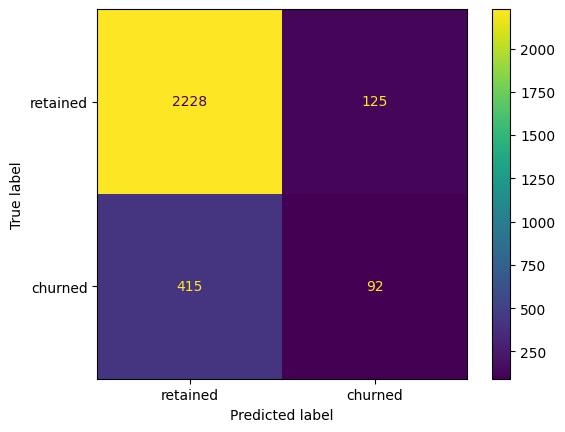

In [67]:
# generate array of values for confusion matrix
cm = confusion_matrix(y_test, xgb_test_preds, labels=xgb_cv.classes_)

# plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=['retained', 'churned'])
disp.plot()

The model correctly identified only 18.1% of the users who actually churned. 

#### Feature Importance

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

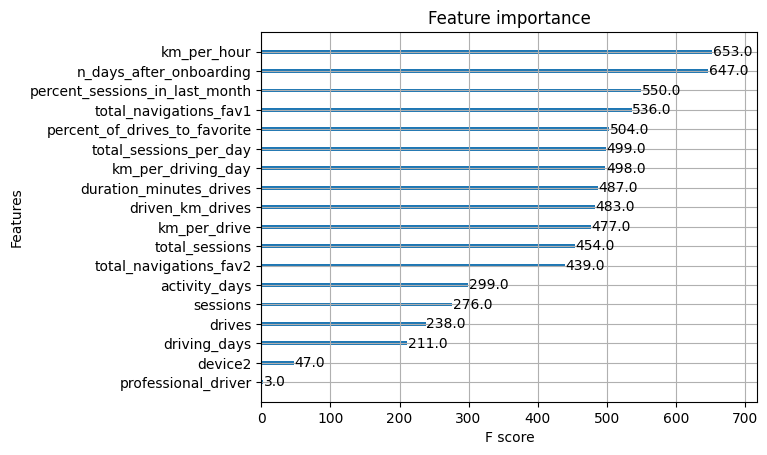

In [69]:
plot_importance(xgb_cv.best_estimator_)

The engineered features accounted for six of the top 10 features, reinforcing that feature engineering is often one of the best ways to boost model performance.